In [1]:
# For wide monitor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
data = pd.read_csv('./IMDB Dataset.csv', engine='python')

In [3]:
data = data[['review', 'sentiment']]
print(data.shape)

(50000, 2)


In [5]:
import re
data['review'] = data['review'].apply((lambda x: re.sub(r'[^A-Za-z0-9\s]', '', x)))

In [6]:
data.review

0        One of the other reviewers has mentioned that ...
1        A wonderful little production br br The filmin...
2        I thought this was a wonderful way to spend ti...
3        Basically theres a family where a little boy J...
4        Petter Matteis Love in the Time of Money is a ...
5        Probably my alltime favorite movie a story of ...
6        I sure would like to see a resurrection of a u...
7        This show was an amazing fresh  innovative ide...
8        Encouraged by the positive comments about this...
9        If you like original gut wrenching laughter yo...
10       Phil the Alien is one of those quirky films wh...
11       I saw this movie when I was about 12 when it c...
12       So im not a big fan of Bolls work but then aga...
13       The cast played Shakespearebr br Shakespeare l...
14       This a fantastic movie of three prisoners who ...
15       Kind of drawn in by the erotic scenes only to ...
16       Some films just simply should not be remade Th.

In [7]:
from keras.preprocessing.text import Tokenizer
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True, oov_token=True)
tokenizer.fit_on_texts(data.review.values)

Using TensorFlow backend.


In [17]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production br br The filmin...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically theres a family where a little boy J...,negative
4,Petter Matteis Love in the Time of Money is a ...,positive


In [8]:
from keras.preprocessing.sequence import pad_sequences
# pad_sequences: 길이가 같지 않고 적거나 많을 때 일정한 길이로 맞춰 줄 때 사용
# 문장의 길이를 maxlen 인자로 맞춰줌. 예를 들어, 200으로 지정했다면 200보다 짧은 문장은 0으로 채워서 200 단어로 맞춰주고 200보다 긴 문장은 200단어까지만 잘라냄
# (num_samples, num_timesteps)으로 2차원의 numpy 배열로 만들어줌. maxlen을 200으로 지정했다면, num_timestamps도 200이 됨.
max_sentence_len = 40
X = tokenizer.texts_to_sequences(data.review.values)
X = pad_sequences(X, maxlen = max_sentence_len)
Y = pd.get_dummies(data.sentiment).values
print("Data Shape: ", X.shape)
print("Label Shape: ", Y.shape)

Data Shape:  (50000, 40)
Label Shape:  (50000, 2)


In [19]:
X.shape[1]

40

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=1)
print(Y_train.shape, X_train.shape)
print(Y_test.shape, X_test.shape)

(25000, 2) (25000, 40)
(25000, 2) (25000, 40)


In [11]:
# https://tykimos.github.io/2017/08/17/Text_Input_Binary_Classification_Model_Recipe/
# 순환 신경망 모델
# 임베딩 레이어 다음에 LSTM레이어가 오는 경우에는 임베딩 레이어에 input_length 인자를 따로 설정할 필요는 없음. 
# 입력 문장의 길이에 따라 input_length가 자동으로 정해지고, 이것이 LSTM 레이어에는 timesteps으로 입력되기 때문.

from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense
embed_dim = 256

# 이 네트워크는 하나의 LSTM 층과 그 뒤에 Dense 분류기가 뒤따릅니다. 분류기는 가능한 모든 글자에 대한 소프트맥스 출력을 만듭니다.
model = Sequential()
# keras.layers.Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None)
# embedding: 단어를 의미론적 기하공간에 매핑할 수 있도록 벡터화시킨다.
# embedding layer 첫번째 인자(input_dim): 단어 사전의 크기를 말하며 총 2,000개의 단어 종류가 있다는 의미임
# 두번째 인자(output_dim): 단어를 인코딩한 후 나오는 벡터 크기. 이 값이 256이라면 단어를 256차원의 의미론적 기하공간에 나타낸다는 것. 
# 단순하게 빈도수만으로 단어를 표시한다면, 10과 11은 빈도수는 비슷하지만 단어로 볼 때는 전혀 다른 의미를 가지고 있음
# 하지만 의미론적으로 잘 설계된 공간에 위치시켜 벡터로 수치화 시킨다고 볼 수 있음
# input_length: 단어의 수 즉 문장의 길이를 나타냄. 임베딩 레이어의 출력 크기는 샘플 수 *output_dim*input_length가 됨
# 임베딩 레이어 다음에 Flatten 레이어가 온다면 반드시 input_length를 지정해야함. 플래튼 레이어인 경우 입력 크기를 알아야 이를 1차원으로 만들어서 dense레이어에 전달할 수 있기 때문.
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))

model.add(LSTM(128, activation='relu', dropout=0.5))
# dense: 은닉층
model.add(Dense(2, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 256)           512000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 709,378
Trainable params: 709,378
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
# optimizer: 훈련 과정을 설정. 
# loss: 최적화 과정에서 최소화될 손실 함수를 설정
# metrics: 훈련을 모니터링하기 위해 사용됨.

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                   epochs=100, batch_size=1000, shuffle=True, verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/100
 - 36s - loss: 0.2015 - acc: 0.9208 - val_loss: 1.0673 - val_acc: 0.7550
Epoch 2/100
 - 26s - loss: 0.1052 - acc: 0.9568 - val_loss: 1.3389 - val_acc: 0.7512
Epoch 3/100
 - 27s - loss: 0.0885 - acc: 0.9633 - val_loss: 1.4993 - val_acc: 0.7500
Epoch 4/100
 - 26s - loss: 0.0806 - acc: 0.9651 - val_loss: 1.6044 - val_acc: 0.7510
Epoch 5/100
 - 25s - loss: 0.0800 - acc: 0.9660 - val_loss: 1.5690 - val_acc: 0.7465
Epoch 6/100
 - 25s - loss: 0.0844 - acc: 0.9649 - val_loss: 1.6636 - val_acc: 0.7482
Epoch 7/100
 - 26s - loss: 0.0774 - acc: 0.9678 - val_loss: 1.6066 - val_acc: 0.7433
Epoch 8/100
 - 25s - loss: 0.0722 - acc: 0.9702 - val_loss: 1.6779 - val_acc: 0.7463
Epoch 9/100
 - 24s - loss: 0.0691 - acc: 0.9718 - val_loss: 1.7068 - val_acc: 0.7476
Epoch 10/100
 - 26s - loss: 0.0701 - acc: 0.9711 - val_loss: 1.7767 - val_acc: 0.7460
Epoch 11/100
 - 25s - loss: 0.0707 - acc: 0.9712 - val_loss: 1.6967 - val_acc: 0.7452
Epoch 12/100


Epoch 96/100
 - 23s - loss: 0.0100 - acc: 0.9971 - val_loss: 2.2902 - val_acc: 0.7457
Epoch 97/100
 - 24s - loss: 0.0096 - acc: 0.9977 - val_loss: 2.2963 - val_acc: 0.7461
Epoch 98/100
 - 23s - loss: 0.0106 - acc: 0.9964 - val_loss: 2.3471 - val_acc: 0.7417
Epoch 99/100
 - 23s - loss: 0.0141 - acc: 0.9959 - val_loss: 2.3244 - val_acc: 0.7494
Epoch 100/100
 - 1260s - loss: 0.0147 - acc: 0.9953 - val_loss: 2.2731 - val_acc: 0.7454


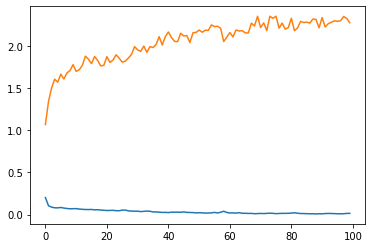

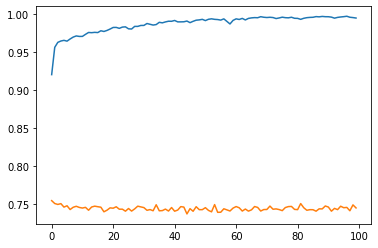

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [15]:
import numpy as np
sentence = 'I love bvanilla super'
sentence = tokenizer.texts_to_sequences([sentence])
sentence= pad_sequences(sentence, maxlen=max_sentence_len, dtype='int32', value=0)
sentiment =model.predict(sentence)[0]
if(np.argmax(sentiment)==0):
    print("Negative")
else:
    print("Positive")

Positive
